In [16]:
import msgpack as mp
import msgpack_numpy as mpn
import numpy as np
import cv2
import matplotlib.pyplot as plt
import sys
import os

sys.path.append(os.path.join(os.getcwd(), ".."))
from support.generate_ar_data import *
from support.pd_support import *
from support.calculations_support import *

In [17]:
#data path
_folder_name = "random_t0"

_base_pth = r"C:\Users\Sujith\Documents\Projects\skateboard_gui\recording_programs\test_data\single_cam_sep_30"
_pth = os.path.join(_base_pth, _folder_name)


In [18]:
#calibration path
_calib_pth = os.path.join(_base_pth, "calibration5")
_webcam_calib_pth = os.path.join(_calib_pth, "webcam_calibration.msgpack")

#rotation matrix path
_rotmat_pth = r"C:\Users\Sujith\Documents\Projects\skateboard_gui\recording_programs\test_data\multiple_cam_sep_16\calibration4"
_webcam_rotmat_pth = os.path.join(_rotmat_pth, "webcam_rotmat.msgpack")
_webcam_video_pth = os.path.join(_pth, "webcam_color.msgpack")

#timestamp path
_webcam_timestamp_pth = os.path.join(_pth, "webcam_timestamp.msgpack")
_webcam_calib_pth

'C:\\Users\\Sujith\\Documents\\Projects\\skateboard_gui\\recording_programs\\test_data\\single_cam_sep_30\\calibration5\\webcam_calibration.msgpack'

In [19]:
#open the calibration files
with open(_webcam_calib_pth, "rb") as f:
    webcam_calib = mp.Unpacker(f, object_hook=mpn.decode)
    _temp = next(webcam_calib)
    _webcam_cam_mat = _temp[0]
    _webcam_dist = _temp[1]

# open rotation matrix and org
    
with open(_webcam_rotmat_pth, "rb") as f:
    webcam_rotmat = mp.Unpacker(f, object_hook=mpn.decode)
    _webcam_rot = next(webcam_rotmat)
    _webcam_org = next(webcam_rotmat)

In [20]:
_w_df = get_ar_pose_data(_webcam_video_pth, _webcam_cam_mat, _webcam_dist, is_color=False, single_file=True, flip_frame=False)

_w_df = add_time_from_file(_w_df, _webcam_timestamp_pth)


returning dataframe


In [22]:
#reading mocap df
_mocap_pth = os.path.join(_base_pth, "csv_files_t2","sk10_random_sweep_t0.csv")
_m_df, st_time = read_df_csv(_mocap_pth)
#getting center

_m_df["x"] = _m_df["LB_x"] + _m_df["RB_x"] + _m_df["LT_x"] + _m_df["RT_x"]
_m_df["y"] = _m_df["LB_y"] + _m_df["RB_y"] + _m_df["LT_y"] + _m_df["RT_y"]
_m_df["z"] = _m_df["LB_z"] + _m_df["RB_z"] + _m_df["LT_z"] + _m_df["RT_z"]

_m_df["x"] = _m_df["x"] / 4
_m_df["y"] = _m_df["y"] / 4
_m_df["z"] = _m_df["z"] / 4

_m_df = add_datetime_col(_m_df, st_time,_name="seconds")

In [23]:
def transform_coordinates_1(df, rotmat, org):
    df1 = df.copy( deep=True)
    for i in range(len(df)):
        val = df[["x", "y", "z"]].loc[i].values
        val = np.reshape(val, (3,1))
        _temp = val - org
        translation_correction = np.array([0.045, -0.05, 0.045]).reshape(3, 1)
        _val = rotmat.T @ _temp
        _val = _val + translation_correction
        df1["x"].loc[i] = _val[0]
        df1["y"].loc[i] = _val[1]
        df1["z"].loc[i] = _val[2]
        # df[["nx", "ny", "nz"]].loc[i] = _val.T[0]
    return df1

In [24]:

w_df = None

w_df = transform_coordinates_1(_w_df, _webcam_rot, _webcam_org)

c:\Users\Sujith\anaconda3\envs\py37\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


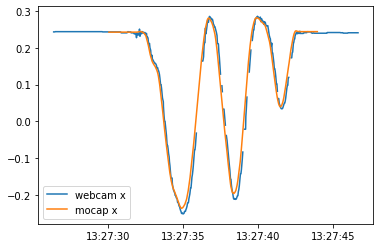

In [25]:

plt.plot(_w_df["time"], _w_df["x"], label="webcam x")
plt.plot(_m_df["time"], _m_df["x"], label="mocap x")
plt.legend()

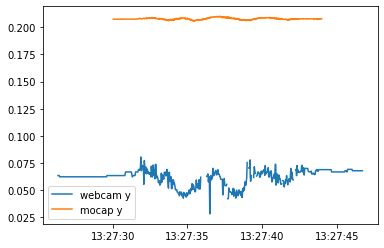

In [26]:

plt.plot(_w_df["time"], w_df["y"], label="webcam y")
plt.plot(_m_df["time"], _m_df["y"], label="mocap y")
plt.legend()

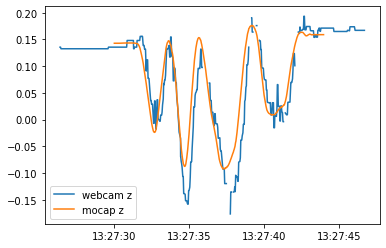

In [35]:

plt.plot(_w_df["time"], w_df["z"].rolling(3).median()-0.18, label="webcam z")
plt.plot(_m_df["time"], _m_df["z"], label="mocap z")
plt.legend()

In [ ]:
#percentage of nan values in each column

percent_missing = w_df.isnull().sum() * 100 / len(w_df)
w_df_missing = pd.DataFrame({'column_name': w_df.columns,
                                    'percent_missing': percent_missing})    
percent_missing = None


In [ ]:

print(w_df_missing)

         column_name  percent_missing
frame_id    frame_id         0.000000
x                  x         3.255814
y                  y         3.255814
z                  z         3.255814
yaw              yaw         3.255814
pitch          pitch         3.255814
roll            roll         3.255814
time            time         0.000000
         column_name  percent_missing
frame_id    frame_id          0.00000
x                  x         35.15625
y                  y         35.15625
z                  z         35.15625
yaw              yaw         35.15625
pitch          pitch         35.15625
roll            roll         35.15625
time            time          0.00000
         column_name  percent_missing
frame_id    frame_id              0.0
x                  x              0.0
y                  y              0.0
z                  z              0.0
yaw              yaw              0.0
pitch          pitch              0.0
roll            roll              0.0
time        